In [55]:
import re

log_file_path = "../../data/log/log6.log"

# 读取日志
with open(log_file_path, "r", encoding="utf-8") as f:
    log_text = f.read()

# 按关键字拆分日志
sections = re.split(r"(Sandbox logs:|Activities log:|Trade History:)", log_text)

# 存储不同部分
logs = {
    "sandbox": "",
    "activities": "",
    "trade_history": ""
}

current_section = None
for section in sections:
    section = section.strip()
    if section == "Sandbox logs:":
        current_section = "sandbox"
    elif section == "Activities log:":
        current_section = "activities"
    elif section == "Trade History:":
        current_section = "trade_history"
    elif current_section:
        logs[current_section] += section + "\n"



In [56]:
# 输出拆分结果
print("🔥 Sandbox Logs:\n", logs["sandbox"][:5000])
#print("\n🔥 Activities Logs:\n", logs["activities"])
#print("\n🔥 Trade History:\n", logs["trade_history"])

🔥 Sandbox Logs:
 {
  "sandboxLog": "",
  "lambdaLog": "traderData: \nObservations: (plainValueObservations: {}, conversionObservations: {})\nCurrent position : {}\nBuy Order depth : 3, Sell order depth : 1\ndepth of ask order: 0, price: 2029, amount: -31\ndepth of bid order: 0, price: 2028, amount: 1\nUsing order depth to estimate fair price\nFair price : 2027.078125\nExpect bid : 2027.073125\nExpect ask : 2027.083125\nBidding price too high, price: 2028, expect_bid: 2027.073125\ndepth of ask order: 0, price: 2029, amount: -31\ndepth of bid order: 1, price: 2026, amount: 2\nUsing order depth to estimate fair price\nFair price : 2027.078125\nExpect bid : 2027.073125\nExpect ask : 2027.083125\nSpread is profitable, spread_pct: 0.15\nNo position, executing market making\n[[2028, 1], [2026, 2], [2025, 29]] 1\nExecuting market making: Buy 2 at 2026, Sell 2 at 2029",
  "timestamp": 0
}
{
  "sandboxLog": "",
  "lambdaLog": "traderData: SAMPLE\nObservations: (plainValueObservations: {}, conver

In [57]:
#使用正则表达式分割多个 JSON 结构

def extract_outer_json_objects(logs):
    """
    提取最外层的 JSON 对象
    """
    objects = []
    depth = 0
    current_object = []
    
    # 遍历字符串中的每个字符
    for char in logs:
        if char == '{':
            if depth == 0:
                current_object.append(char)  # 开始新对象
            depth += 1
        elif char == '}':
            depth -= 1
            if depth == 0:
                current_object.append(char)  # 结束当前对象
                objects.append(''.join(current_object))  # 存储最外层对象
                current_object = []  # 重置当前对象
            else:
                current_object.append(char)  # 内部的嵌套对象继续追加
        elif depth > 0:
            current_object.append(char)  # 在内部对象中继续添加字符

    return objects

json_objects = extract_outer_json_objects(logs['sandbox'])
print(json_objects[:10])

['{\n  "sandboxLog": "",\n  "lambdaLog": "traderData: \\nObservations: (plainValueObservations: }, conversionObservations: })\\nCurrent position : }\\nBuy Order depth : 3, Sell order depth : 1\\ndepth of ask order: 0, price: 2029, amount: -31\\ndepth of bid order: 0, price: 2028, amount: 1\\nUsing order depth to estimate fair price\\nFair price : 2027.078125\\nExpect bid : 2027.073125\\nExpect ask : 2027.083125\\nBidding price too high, price: 2028, expect_bid: 2027.073125\\ndepth of ask order: 0, price: 2029, amount: -31\\ndepth of bid order: 1, price: 2026, amount: 2\\nUsing order depth to estimate fair price\\nFair price : 2027.078125\\nExpect bid : 2027.073125\\nExpect ask : 2027.083125\\nSpread is profitable, spread_pct: 0.15\\nNo position, executing market making\\n[[2028, 1], [2026, 2], [2025, 29]] 1\\nExecuting market making: Buy 2 at 2026, Sell 2 at 2029",\n  "timestamp": 0\n}', '{\n  "sandboxLog": "",\n  "lambdaLog": "traderData: SAMPLE\\nObservations: (plainValueObservations

In [58]:
import json
#解析 JSON 数据
parsed_logs = []
for obj in json_objects:
    try:
        log_data = json.loads(obj)  # 解析 JSON
        lambda_log = log_data.get("lambdaLog", "")

        # 🔍 正则解析 lambdaLog
        patterns = {
            "Current_position": re.compile(r"Current position\s*:\s*(\{.*?\})"),
            "best_ask": re.compile(r"best_ask: (\d+)"),
            "best_bid": re.compile(r"best_bid: (\d+)"),
            "fair_price": re.compile(r"Fair price : ([\d.]+)"),
            "expect_bid": re.compile(r"Expect bid : ([\d.]+)"),
            "expect_ask": re.compile(r"Expect ask : ([\d.]+)"),
            "profit": re.compile(r"Profit: ([\d.]+)")
        }

        parsed_entry = {"timestamp": log_data.get("timestamp")}

        # 提取并解析字段
        for key, pattern in patterns.items():
            match = pattern.search(lambda_log)
            if match:
                if key == "Current_position":
                    # 解析 Current position 为字典
                    current_position_str = match.group(1)
                    try:
                        parsed_entry[key] = ast.literal_eval(current_position_str)  # 将字符串转换为字典
                    except Exception as e:
                        print(f"Error parsing current position: {e}")
                        parsed_entry[key] = {}  # 如果解析失败，设置为空字典
                else:
                    parsed_entry[key] = float(match.group(1)) if match else None  # 转换为浮点数
            else:
                parsed_entry[key] = None  # 如果没有匹配，设置为 None

        parsed_logs.append(parsed_entry)

        parsed_logs.append(parsed_entry)

    except json.JSONDecodeError as e:
        print(f"解析 JSON 失败: {e}")

#输出解析结果
print(json.dumps(parsed_logs[:10], indent=4, ensure_ascii=False))

[
    {
        "timestamp": 0,
        "Current_position": null,
        "best_ask": null,
        "best_bid": null,
        "fair_price": 2027.078125,
        "expect_bid": 2027.073125,
        "expect_ask": 2027.083125,
        "profit": null
    },
    {
        "timestamp": 0,
        "Current_position": null,
        "best_ask": null,
        "best_bid": null,
        "fair_price": 2027.078125,
        "expect_bid": 2027.073125,
        "expect_ask": 2027.083125,
        "profit": null
    },
    {
        "timestamp": 100,
        "Current_position": null,
        "best_ask": null,
        "best_bid": null,
        "fair_price": 2026.9583333333335,
        "expect_bid": 2026.9533333333334,
        "expect_ask": 2026.9633333333336,
        "profit": null
    },
    {
        "timestamp": 100,
        "Current_position": null,
        "best_ask": null,
        "best_bid": null,
        "fair_price": 2026.9583333333335,
        "expect_bid": 2026.9533333333334,
        "expect_ask"

In [34]:
print(parsed_logs[1]['timestamp'])

100


In [ ]:
timestamp_list = []
profit_list = []

for log in parsed_logs:
    timestamp_list.append(log['timestamp'])
    profit_list.append(log['profit'])

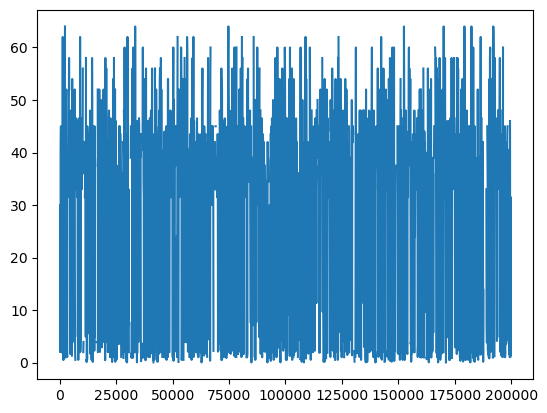

In [37]:
import matplotlib.pyplot as plt
plt.plot(timestamp_list, profit_list)

In [41]:
print(logs['activities'][:1000])

day;timestamp;product;bid_price_1;bid_volume_1;bid_price_2;bid_volume_2;bid_price_3;bid_volume_3;ask_price_1;ask_volume_1;ask_price_2;ask_volume_2;ask_price_3;ask_volume_3;mid_price;profit_and_loss
-1;0;RAINFOREST_RESIN;10002;1;9996;2;9995;29;10004;2;10005;29;;;10003.0;0.0
-1;0;KELP;2028;1;2026;2;2025;29;2029;31;;;;;2028.5;0.0
-1;100;KELP;2025;24;;;;;2028;2;2029;22;;;2026.5;0.0
-1;100;RAINFOREST_RESIN;9996;2;9995;22;;;10004;2;10005;22;;;10000.0;0.0
-1;200;RAINFOREST_RESIN;9995;20;;;;;10005;20;;;;;10000.0;0.0
-1;200;KELP;2025;22;;;;;2028;20;;;;;2026.5;0.0
-1;300;KELP;2025;31;;;;;2028;2;2029;29;;;2026.5;0.0
-1;300;RAINFOREST_RESIN;9996;2;9995;29;;;10004;2;10005;29;;;10000.0;0.0
-1;400;RAINFOREST_RESIN;9996;2;9995;25;;;10004;2;10005;25;;;10000.0;0.0
-1;400;KELP;2025;27;;;;;2028;27;;;;;2026.5;0.0
-1;500;KELP;2025;30;;;;;2028;30;;;;;2026.5;0.0
-1;500;RAINFOREST_RESIN;9995;30;;;;;10002;4;10005;30;;;9998.5;0.0
-1;600;RAINFOREST_RESIN;10000;5;9995;25;;;10005;25;;;;;10002.5;0.0
-1;600;KELP;2026

In [43]:
print(logs['sandbox'][:1000])

{
  "sandboxLog": "",
  "lambdaLog": "traderData: \nObservations: (plainValueObservations: {}, conversionObservations: {})\nCurrent position : {}\nBuy Order depth : 3, Sell order depth : 1\nbest_ask: 2029, best_ask_amount: -31, best_bid: 2028, best_bid_amount: 1\nUsing order depth to estimate fair price\nFair price : 2027.078125\nExpect bid : 2027.073125\nExpect ask : 2027.083125\nNot in market making range\nSkipping RAINFOREST_RESIN",
  "timestamp": 0
}
{
  "sandboxLog": "",
  "lambdaLog": "traderData: SAMPLE\nObservations: (plainValueObservations: {}, conversionObservations: {})\nCurrent position : {}\nBuy Order depth : 1, Sell order depth : 2\nbest_ask: 2028, best_ask_amount: -2, best_bid: 2025, best_bid_amount: 24\nUsing order depth to estimate fair price\nFair price : 2026.9583333333335\nExpect bid : 2026.9533333333334\nExpect ask : 2026.9633333333336\nMarket making\nMarket making profitable. Profit: 2.08333333333303\nSkipping RAINFOREST_RESIN",
  "timestamp": 100
}
{
  "sandboxLo

In [44]:
print(logs['trade_history'][:10000])

[
  {
    "timestamp": 0,
    "buyer": "",
    "seller": "",
    "symbol": "KELP",
    "currency": "SEASHELLS",
    "price": 2029,
    "quantity": 13
  },
  {
    "timestamp": 0,
    "buyer": "",
    "seller": "",
    "symbol": "KELP",
    "currency": "SEASHELLS",
    "price": 2029,
    "quantity": 1
  },
  {
    "timestamp": 0,
    "buyer": "",
    "seller": "",
    "symbol": "RAINFOREST_RESIN",
    "currency": "SEASHELLS",
    "price": 10004,
    "quantity": 1
  },
  {
    "timestamp": 1100,
    "buyer": "",
    "seller": "",
    "symbol": "RAINFOREST_RESIN",
    "currency": "SEASHELLS",
    "price": 9996,
    "quantity": 2
  },
  {
    "timestamp": 1700,
    "buyer": "",
    "seller": "SUBMISSION",
    "symbol": "KELP",
    "currency": "SEASHELLS",
    "price": 2026,
    "quantity": 1
  },
  {
    "timestamp": 1700,
    "buyer": "",
    "seller": "",
    "symbol": "KELP",
    "currency": "SEASHELLS",
    "price": 2026,
    "quantity": 8
  },
  {
    "timestamp": 1700,
    "buyer": "